# Propensity Scoring Matching
### Author: Siyuan Sang

## Data Processing( Done by Catherine Gao)
### 2.1 Load Required Packages

"Y" indicates the outcome variable, "A" is the treatment group assignment, and the rest are covariates for consideration.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# setting graph styles
sns.set(rc={'figure.figsize':(10,8)})
sns.set_theme(style='ticks')


### 2.2 Load Data

In [2]:
# load high dimensional data
highdim_data = pd.read_csv('highDim_dataset.csv')

# load low dimensional data
lowdim_data = pd.read_csv('lowDim_dataset.csv')


In [3]:
print("The high dimensional data has",highdim_data.shape[0],"observations and", highdim_data.shape[1], "variables.")
print("The low dimensional data has",lowdim_data.shape[0],"observations and", lowdim_data.shape[1], "variables.")
      

The high dimensional data has 2000 observations and 187 variables.
The low dimensional data has 500 observations and 24 variables.


## 3 Propensity Scores Estimation and Evaluation(Done by Cathrine Gao)
We will use L1 penalized logistic regression to estimate propensity scores for both data sets.

### 3.1 Create Propensity Score Estimation Functions

In [4]:
# create a function to tune for best hyperparameters for each data set

def best_param(data, random_state, param_grid, cv=10):
    '''
    Purpose: to find the best parameter "C" (coefficient of regularization strength) for the specific dataset
    
    Parameters:
    data - dataset to best tested on 
    random_state - set seed
    param_grid - set of parameter values to test on
    cv - number of folds for cross-validation
    
    '''

    x = data.drop(['A','Y'], axis = 1)  
    y = data[['A']].values.ravel()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)
    
    
    model_cv = GridSearchCV(LogisticRegression(penalty='l1',solver = 'liblinear'), param_grid, cv=cv)
    model_cv.fit(x_train, y_train)
    
    print("The best tuned coefficient of regularization strength is",model_cv.best_params_.get('C'), 
          "with a testing accuracy of", model_cv.score(x_test, y_test))
    
    return model_cv.best_params_.get('C')


In [10]:
def propensity_score(data, C=0.1, plot = True):
    '''
    Purpose: to estimate propensity score with L1 penalized logistic regression
    
    Parameters:
    data - dataset to estimate on 
    C - coeficient of regularization strength
    plot - print out visualization to show distribution of propensity scores
    
    Returns:
    1. ps for Propensity Score
    2. Visualization plot to show distribution of propensity scores
    
    '''
    
    T = 'A'
    Y = 'Y'
    X = data.columns.drop([T,Y])
    
    ps_model = LogisticRegression(random_state=2021, penalty='l1',
                                  solver='liblinear').fit(data[X], data[T]) 
    
    ps = ps_model.predict_proba(data[X])[:,1] # we are interested in the probability of getting a "1"
    
    if plot:
        df_plot = pd.DataFrame({'Treatment':data[T], 'Propensity Score':ps})
        
        sns.histplot(data=df_plot, x = "Propensity Score", hue = "Treatment", element = "step")
        plt.title("Distribution of Propensity Score by Treatment Group", size=20)
        plt.show()
   
    return ps


In [6]:
# setting parameters
param_grid = {"C":[0.01,0.05,0.1,0.3,0.5,0.7,1]}

### 3.2 Evaluate Propensity Scores for High Dimensional Data

In [8]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_high = best_param(highdim_data, random_state=2021, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.01 with a testing accuracy of 0.71


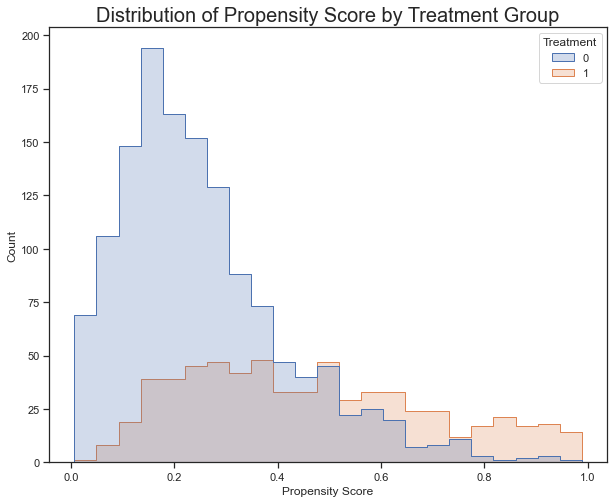

In [11]:
# estimate propsensity scores
ps_high = propensity_score(highdim_data, C = c_high)

### 3.3 Evaluate Propensity Scores for Low Dimensional Data

In [13]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_low = best_param(lowdim_data, random_state=2021, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.3 with a testing accuracy of 0.8


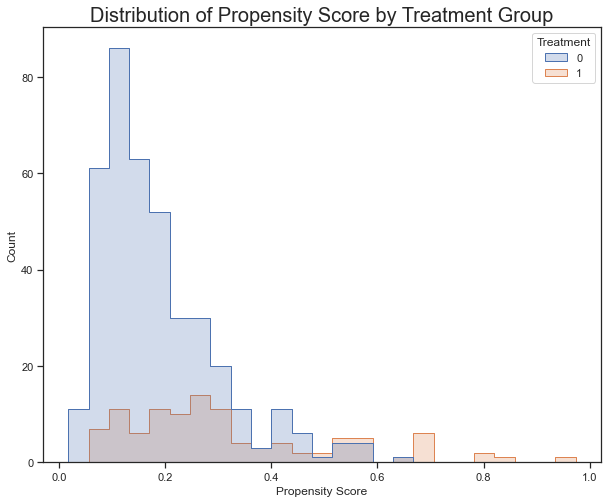

In [14]:
ps_low = propensity_score(lowdim_data, C = c_low)

## Conclusion

Propensity scores have been estimated using L1 penalized logistic regression. For algorithm testing, use ps_low for the low dimensional data and ps_high for the high dimensional data. 

### 4 PSM with Propensity Score Measure
Estimate ATE with the PSM method(PS)

In [15]:
highdim_data['PS']=ps_high
lowdim_data['PS']=ps_low

In [16]:
def PSM(treated_df, control_df):
    
    #Get Distances
    treated_df.loc[:,'group']=None
    treated_df.loc[:,'control_Y']=None
    treated_df.loc[:,'D']=None
    for i in range(len(treated_df)):
        temp_d=[]
        for j in range(len(control_df)):
            temp_d.append(abs(treated_df.loc[i,'PS']-control_df.loc[j,'PS']))
        index=temp_d.index(np.min(temp_d))
        treated_df.loc[i,'control_Y']=control_df.loc[index,'Y']
        treated_df.loc[i,'D']=np.min(temp_d)
        
    #Split class
    #Here, we deide to create 5 subclasses
    r=(max(treated_df.loc[:,'D'])-min(treated_df.loc[:,'D']))/5
    for i in range(len(treated_df)):
        if treated_df.loc[i,'D'] <= min(treated_df.loc[:,'D'])+r:
            treated_df.loc[i,'group']=0
        elif treated_df.loc[i,'D'] > min(treated_df.loc[:,'D'])+r and treated_df.loc[i,'D'] <= min(treated_df.loc[:,'D'])+2*r:
            treated_df.loc[i,'group']=1
        elif treated_df.loc[i,'D'] > min(treated_df.loc[:,'D'])+2*r and treated_df.loc[i,'D'] <= min(treated_df.loc[:,'D'])+3*r:
            treated_df.loc[i,'group']=2
        elif treated_df.loc[i,'D'] > min(treated_df.loc[:,'D'])+3*r and treated_df.loc[i,'D'] <= min(treated_df.loc[:,'D'])+4*r:
            treated_df.loc[i,'group']=3
        else:
            treated_df.loc[i,'group']=4
            
    #Calculate ATE
    TE=[]
    for i in range(5):
        temp=treated_df[treated_df.loc[:,'group']==i]
        a=(temp.loc[:,'Y']-temp.loc[:,'control_Y']).mean()*len(temp)/len(treated_df)    
        TE.append(a)
    ATE=np.nanmean(TE)
    
    return ATE

    

## Perform on low dimention dataset

In [19]:
PS_low_start = time.time()
treated_low=lowdim_data[lowdim_data.A==1]
treated_low.reset_index(drop=True, inplace=True)
control_low=lowdim_data[lowdim_data.A==0]
control_low.reset_index(drop=True, inplace=True)

In [20]:
PS_low_ETA=PSM(treated_low, control_low)
PS_low_end = time.time()
PS_low_accu = (2.0901 - PS_low_ETA)/2.0901
PS_low_time = PS_low_end - PS_low_start

C:\Users\13605\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\13605\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [21]:
print(f'PSM method for low dimensional dataset:\n ETA = {PS_low_ETA:0.2f}\n Accuracy = {PS_low_accu:0.2f}\n PSM running time = {PS_low_time:0.2f}')

PSM method for low dimensional dataset:
 ETA = 0.90
 Accuracy = 0.57
 PSM running time = 1.53


## Perform on high dimention dataset

In [25]:
PS_high_start = time.time()
treated_high=highdim_data[highdim_data.A==1]
treated_high.reset_index(drop=True, inplace=True)
control_high=highdim_data[highdim_data.A==0]
control_high.reset_index(drop=True, inplace=True)

In [26]:
PS_high_ETA=PSM(treated_high, control_high)
PS_high_end = time.time()
PS_high_accu = (54.8558 + PS_high_ETA)/54.8558
PS_high_time = PS_high_end - PS_high_start

C:\Users\13605\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\13605\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [28]:
print(f'PSM method for high dimensional dataset:\n ETA = {PS_high_ETA:0.2f}\n Accuracy = {PS_high_accu:0.2f}\n PSM running time = {PS_high_time:0.2f}')

PSM method for high dimensional dataset:
 ETA = -11.82
 Accuracy = 0.78
 PSM running time = 11.37
